WMH

In [1]:
import torch
from torch import nn

class DoubleConv(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_normalization: bool = True,
    ) -> None:
        super().__init__()

        # This is a little Python trick to make the code more readable
        # You can set a variable to contain a function or class, and then call it later
        conv = None
        norm = None

        if n_dims == 2:
            conv = nn.Conv2d
            norm = nn.BatchNorm2d if use_normalization else nn.Identity
        elif n_dims == 3:
            conv = nn.Conv3d
            norm = nn.BatchNorm3d if use_normalization else nn.Identity
        else:
            raise ValueError("Invalid number of dimensions")
        
        layers = [
            conv(in_channels , in_channels , kernel_size=3, padding=1),   # For kernel_size=3, padding=1, and the default stride=1, the output size equals the input size.
            norm(in_channels ),                                   # Does Normalization change the dimension of the image?
            nn.ReLU(inplace=True),                        # Does a ReLu activation layer change the dimension of the image?
            conv(in_channels , out_channels , kernel_size=3, padding=1),         
            norm(out_channels),                                      
            nn.ReLU(inplace=True),                          
        ]

        # This is a Python specific syntax to "unpack" the list of layers
        # and pass them as arguments to nn.Sequential
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)
    
class EncoderBlock(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_normalization: bool = True,
    ) -> None:
        super().__init__()

        pool = None
        if n_dims == 2:
            pool = nn.MaxPool2d(kernel_size=2, stride=2)
        elif n_dims == 3:
            pool = nn.MaxPool3d(kernel_size=2, stride=2)
        else:
            raise ValueError("Invalid number of dimensions")

        self.encode = nn.Sequential(
            pool,
            DoubleConv(n_dims, in_channels, out_channels, use_normalization),
        )

    def forward(self, x):
        return self.encode(x)

In [2]:
class DecoderBlock(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_transpose: bool = False,
        use_normalization: bool = True,
    ) -> None:
        super().__init__()

        # Our earlier trick to make the code more readable
        # Unfortunately doesn't work quite as nicely here because 
        # nn.Upsample and nn.ConvTranspose have different signatures
        conv = None

        if n_dims == 2:
            conv = nn.Conv2d

            # Two methods to upsample: transpose or with interpolation
            ## Upsample the spatial dimensions (height, width) and reduce the number of channels by half.
            if use_transpose:
                self.upsample = nn.ConvTranspose2d(in_channels , out_channels , kernel_size=2, stride=2)  # We cut the number of in-channels in half. How this operation affects the other dimensions?
            else:
                self.upsample = nn.Sequential(  # We want to the same image dimension as by using use_transpose
                    nn.Upsample(   # What is it changing here? 
                        scale_factor= 2 ,  
                        mode="bilinear",
                        align_corners=True
                    ),
                    conv(in_channels , out_channels , kernel_size=1, padding=0),  # We performe a 1x1 convolution. Why is this useful? Did the image change shape?
                )
        elif n_dims == 3:
            conv = nn.Conv3d

            # Same as with the 2D case. 
            if use_transpose:
                self.upsample = nn.ConvTranspose3d(in_channels, out_channels , kernel_size=2, stride=2)
            else:
                self.upsample = nn.Sequential(
                    nn.Upsample(
                        scale_factor= 2 ,
                        mode="trilinear",   # Why do we use trilinear interpolation here and not bilinear? What is the difference?
                        align_corners=True
                    ),
                    conv(in_channels, out_channels, kernel_size=1, padding=0),
                )
        
        self.decode = DoubleConv(n_dims, in_channels, out_channels, use_normalization)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)
        
        # This is the skip connection
        x = torch.cat((x, skip), dim=1)
        x = self.decode(x)
        return x

In [3]:
class UNet(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        base_channels: int = 8,
        depth: int = 4,
        use_transpose: bool = False,
        use_normalization: bool = True,
        final_activation: nn.Module | None = None,
    ) -> None:
        super().__init__()

        self.n_dims = n_dims
        self.depth = depth

        if depth < 2:
            raise ValueError("Model depth must be 2 or greater")
        
        # Define the input layer
        layers = [DoubleConv(n_dims, in_channels , base_channels , use_normalization)]
        
        # Define the encoder path: it progressively doubles the number of channels
        current_features = base_channels
        for _ in range(depth - 1):
            layers.append(EncoderBlock(n_dims, current_features, current_features * 2 , use_normalization))
            current_features *= 2

        # Define the decoder path: progressively halves the number of channels
        for _ in range(depth - 1):
            layers.append(DecoderBlock(n_dims, current_features, current_features // 2 , use_transpose, use_normalization))
            current_features //= 2
        
        # Define the output layer
        if n_dims == 2:
            layers.append(nn.Conv2d(current_features, out_channels, kernel_size=1))
        elif n_dims == 3:
            layers.append(nn.Conv3d(current_features, out_channels, kernel_size=1))
        else:
            raise ValueError("Invalid number of dimensions")
        
        self.layers = nn.ModuleList(layers)
        if final_activation is not None:
            self.final_activation = final_activation
        else:
            self.final_activation = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xi = [self.layers[0](x)]

        # Encoder path
        # Pretty simple, just loop over the encoder blocks
        for layer in self.layers[1:self.depth]:
            xi.append(layer(xi[-1]))
        
        # Decoder path
        # We need to loop over the decoder blocks, but also need to
        # keep track of the skip connections
        for i, layer in enumerate(self.layers[self.depth:-1]):
            xi[-1] = layer(xi[-1], xi[-2 - i])
        
        return self.final_activation(self.layers[-1](xi[-1]))

In [4]:
def preprocess(
    image: torch.Tensor,
    label: torch.Tensor | None = None,
    crop_size: tuple[int, ...] = (28, 28, 28)
) -> tuple[torch.Tensor, torch.Tensor]:
    
    # Normalize the image (Z-score normalization)
    image = (image - image.mean() ) / image.std()
    
    # Add a channel dimension to the image
    image = image.unsqueeze(0)

    # Random crop
    crop_origin = [0, 0, 0]
    for dim in range(3):  # Remember, image.shape = [Ch, X, Y, Z ]
        max_value = image.shape[dim+1] - crop_size[dim]
        crop_origin[dim] = torch.randint(0, max_value, (1,)).item()
        
    image = image[
        :,
        crop_origin[0]:crop_origin[0] + crop_size[0],
        crop_origin[1]:crop_origin[1] + crop_size[1],
        crop_origin[2]:crop_origin[2] + crop_size[2],
    ]
    
    # Add a channel dimension to the label
    if label is not None:
        label = label.unsqueeze(0)

        label = label[
            :,
            crop_origin[0]:crop_origin[0] + crop_size[0],
            crop_origin[1]:crop_origin[1] + crop_size[1],
            crop_origin[2]:crop_origin[2] + crop_size[2],
        ]
    
    return image, label

In [5]:
import SimpleITK as sitk
from torch.utils.data import DataLoader, Dataset

from pathlib import Path


def collect_samples(root: Path, is_test: bool = False) -> list[dict[str, Path]]:
    """
    Collects the samples from the Medical Decathlon dataset.

    Parameters
    ----------
    root : Path
        The root directory of the dataset.
    is_test : bool
        Whether to collect the test set or the training set.

    Returns
    -------
    list[dict[str, Path]]
        A list of dictionaries containing the image and label paths.
    """
  
   # if test_set:
    #    image_dir = root / "imagesTs"
   #     label_dir = None
   # else:
    #    image_dir = root / "imagesTr"
     #   label_dir = root / "labelsTr"
    #samples = []
    samples = []
    # Iterate through each subject directory
    for subject_dir in root.iterdir():
        if subject_dir.is_dir():  # Check if it's a directory
            flair_path = subject_dir / "FLAIR.nii.gz"
            t1_path = subject_dir / "T1.nii.gz"
            WMH_path = subject_dir / "wmh.nii.gz"
            
            # Check if all required files exist
            if flair_path.exists() and t1_path.exists() and WMH_path.exists():
                sample = {
                    "flair": flair_path,
                    "t1": t1_path,
                    "WMH": WMH_path
                }
                samples.append(sample)
            else:
                print(f"Missing files in {subject_dir}: "
                      f"{'FLAIR' if not flair_path.exists() else ''} "
                      f"{'T1' if not t1_path.exists() else ''} "
                      f"{'wmh' if not WMH_path.exists() else ''}")

    return samples

class MedicalDecathlonDataset(Dataset):
    def __init__(self, samples: list[tuple[Path, ...]], test: bool = False) -> None:
        self.samples = samples 
        
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor] | torch.Tensor:
        image_path, label_path = self.samples[idx]
        
        image = sitk.ReadImage(image_path)
        image_array = sitk.GetArrayFromImage(image)
        image = torch.tensor(image_array,dtype=torch.float32)  # Convert image to PyTorch tensor and cast it to float

        if label_path is None:
           image, _ = preprocess(image)
           return image

        label = sitk.ReadImage(label_path)
        label_array = sitk.GetArrayFromImage(label)
        label = torch.tensor(label_array,dtype=torch.float32)

        return preprocess(image, label)

In [6]:
from monai import transforms as mt
from monai.data import CacheDataset

train_transforms = mt.Compose([
    mt.LoadImaged(keys=["image", "label"]),
    mt.EnsureChannelFirstd(keys=["image", "label"]),
    mt.NormalizeIntensityd(keys=["image"]),
    mt.RandSpatialCropd(keys=["image", "label"], roi_size=[28, 28, 28]),
    # You can add more transforms here! See
    # https://docs.monai.io/en/stable/transforms.html#dictionary-transforms
])

val_transforms = mt.Compose([
    mt.LoadImaged(keys=["image", "label"]),
    mt.EnsureChannelFirstd(keys=["image", "label"]),
    mt.NormalizeIntensityd(keys=["image"]),
])

root = Path(r"C:/Users/20213084/OneDrive - TU Eindhoven/Desktop/8UU22/Group project/WMH/WMH/Utrecht/0").resolve()
samples = collect_samples(root)

train_samples = samples[:int(len(samples) * 0.8)]
val_samples = samples[int(len(samples) * 0.8):]

# You might get an error here, make sure you install the required extra dependencies
# https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies
train_ds = CacheDataset(data=train_samples, transform= train_transforms)
val_ds   = CacheDataset(data=val_samples,   transform= val_transforms)

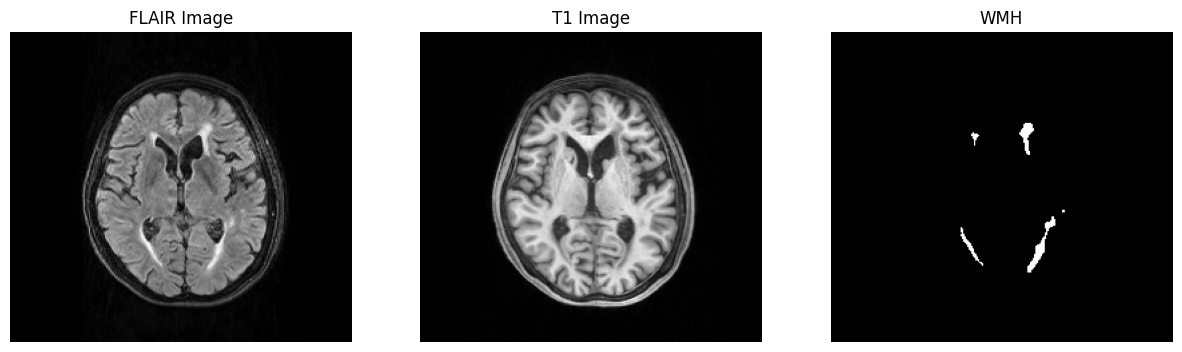

60

In [7]:
import SimpleITK as sitk
import matplotlib.pyplot as plt  # Correct import for pyplot
from pathlib import Path

def load_nifti_image(image_path: Path):
    """Load a NIfTI image using SimpleITK."""
    image = sitk.ReadImage(str(image_path))
    return sitk.GetArrayFromImage(image)  # Convert to NumPy array

def visualize_sample(sample):
    """Visualize FLAIR, T1, and WMH images from a sample."""
    flair_image = load_nifti_image(sample['flair'])
    t1_image = load_nifti_image(sample['t1'])
    label_image = load_nifti_image(sample['WMH'])

    # Select a slice to visualize (e.g., the middle slice)
    slice_index = flair_image.shape[0] // 2

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # FLAIR Image
    axes[0].imshow(flair_image[slice_index, :, :], cmap='gray')
    axes[0].set_title('FLAIR Image')
    axes[0].axis('off')

    # T1 Image
    axes[1].imshow(t1_image[slice_index, :, :], cmap='gray')
    axes[1].set_title('T1 Image')
    axes[1].axis('off')

    # WMH Label
    axes[2].imshow(label_image[slice_index, :, :], cmap='gray')
    axes[2].set_title('WMH')
    axes[2].axis('off')
    plt.show()

# Example usage
root = Path(r"./WMH/WMH/Singapore").resolve()
root2 = Path(r"./WMH/WMH/Singapore").resolve()
root3 = Path(r"./WMH/WMH/Utrecht").resolve()
samples = collect_samples(root) + collect_samples(root2) + collect_samples(root3)

# Visualize the first sample if available
if samples:
    visualize_sample(samples[0])  # Visualize the first sample
else:
    print("No samples found to visualize.")
len(samples)

In [9]:
import os
import nibabel as nib
from pathlib import Path
import cv2
import numpy as np
from scipy.ndimage import zoom

# Specify the directory containing the .nii.gz files
dataset_path = Path(r"./WMH/WMH/Amsterdam/101")
resized_data_dict1 = {}
# List all .nii.gz files in the directory
nii_files = list(dataset_path.glob("*.nii.gz"))
new_shape1 = (240, 256, 155)
# Load each .nii.gz file and print its shape
for nii_file in nii_files:
    img = nib.load(nii_file)
    data = img.get_fdata()  # Get the image data as a NumPy array
    print(f"Loaded {nii_file.name} with original shape: {data.shape}")  # Height, Width, Depth

    # Calculate the zoom factors for each dimension
    zoom_factors1 = [new_dim / old_dim for new_dim, old_dim in zip(new_shape1, data.shape)]
    
    # Resize the data using zoom
    resized_data1 = zoom(data, zoom_factors1, order=1)  # Use order=1 for linear interpolation
    resized_data_dict1[nii_file.name] = resized_data1
    print(f"Resized {nii_file.name} to shape: {resized_data1.shape}")  # New shape

Loaded FLAIR.nii.gz with original shape: (132, 256, 83)
Resized FLAIR.nii.gz to shape: (240, 256, 155)
Loaded T1.nii.gz with original shape: (132, 256, 83)
Resized T1.nii.gz to shape: (240, 256, 155)
Loaded wmh.nii.gz with original shape: (132, 256, 83)
Resized wmh.nii.gz to shape: (240, 256, 155)


In [10]:
import os
import nibabel as nib
from pathlib import Path
import cv2
import numpy as np
from scipy.ndimage import zoom
# Specify the directory containing the .nii.gz files
dataset_path = Path(r"./BraTS\BraTS\Data\BraTS2021_00002")
resized_data_dict = {}
# List all .nii.gz files in the directory
nii_files = list(dataset_path.glob("*.nii.gz"))
new_shape = (240, 256, 155)  # Change this to your desired shape
# Load each .nii.gz file and print its shape
for nii_file in nii_files:
    img = nib.load(nii_file)
    data = img.get_fdata()  # Get the image data as a NumPy array
    print(f"Loaded {nii_file.name} with original shape: {data.shape}")  # Height, Width, Depth

    # Calculate the zoom factors for each dimension
    zoom_factors = [new_dim / old_dim for new_dim, old_dim in zip(new_shape, data.shape)]
    
    # Resize the data using zoom
    resized_data = zoom(data, zoom_factors, order=1)  # Use order=1 for linear interpolation
    resized_data_dict[nii_file.name] = resized_data
    print(f"Resized {nii_file.name} to shape: {resized_data.shape}")  # New shape

Loaded BraTS2021_00002_flair.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_flair.nii.gz to shape: (240, 256, 155)
Loaded BraTS2021_00002_seg.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_seg.nii.gz to shape: (240, 256, 155)
Loaded BraTS2021_00002_t1.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_t1.nii.gz to shape: (240, 256, 155)
Loaded BraTS2021_00002_t1ce.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_t1ce.nii.gz to shape: (240, 256, 155)
Loaded BraTS2021_00002_t2.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_t2.nii.gz to shape: (240, 256, 155)


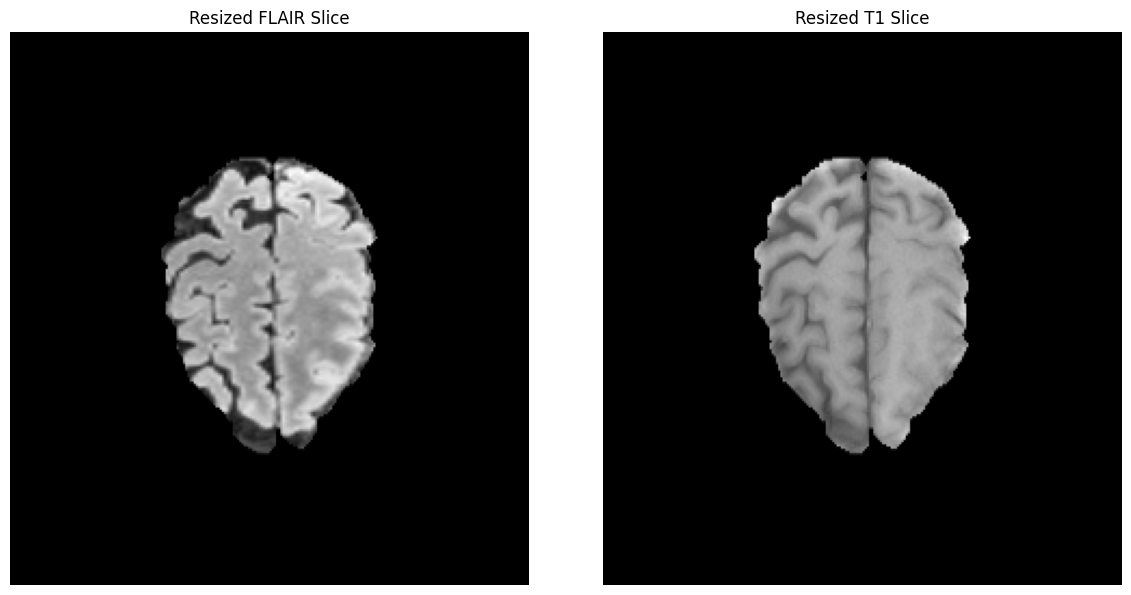

In [18]:

# Visualize the resized FLAIR and T1 images
flair_data = resized_data_dict.get('BraTS2021_00002_flair.nii.gz')  # Replace with the actual filename for FLAIR
t1_data = resized_data_dict.get('BraTS2021_00002_t1.nii.gz')  # Replace with the actual filename for T1

# Check if both images are loaded
if flair_data is not None and t1_data is not None:
    # Get the middle slice index
    slice_index = flair_data.shape[0] // 2  # Assuming both have the same depth

    # Extract slices
    flair_slice = flair_data[:, :, slice_index]
    t1_slice = t1_data[:, :, slice_index]

    # Plot the slices side by side
    plt.figure(figsize=(12, 6))  # Set the figure size
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(flair_slice.T, cmap='gray', origin='lower')  # Transpose for correct orientation
    plt.title('Resized FLAIR Slice')
    plt.axis('off')  # Turn off axis

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(t1_slice.T, cmap='gray', origin='lower')  # Transpose for correct orientation
    plt.title('Resized T1 Slice')
    plt.axis('off')  # Turn off axis

    plt.tight_layout()  # Adjust layout
    plt.show()
else:
    print("FLAIR or T1 data not found.")

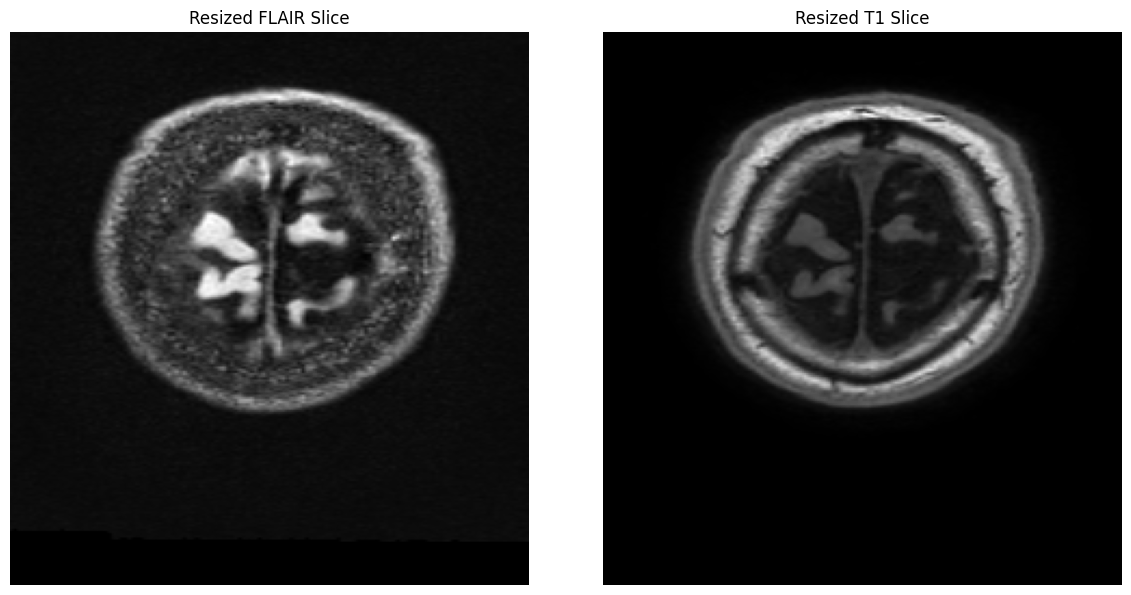

In [21]:

# Visualize the resized FLAIR and T1 images
flair_data = resized_data_dict1.get('FLAIR.nii.gz')  # Replace with the actual filename for FLAIR
t1_data = resized_data_dict1.get('T1.nii.gz')  # Replace with the actual filename for T1

# Check if both images are loaded
if flair_data is not None and t1_data is not None:
    # Get the middle slice index
    slice_index = flair_data.shape[0] // 2  # Assuming both have the same depth

    # Extract slices
    flair_slice = flair_data[:, :, slice_index]
    t1_slice = t1_data[:, :, slice_index]

    # Plot the slices side by side
    plt.figure(figsize=(12, 6))  # Set the figure size
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(flair_slice.T, cmap='gray', origin='lower')  # Transpose for correct orientation
    plt.title('Resized FLAIR Slice')
    plt.axis('off')  # Turn off axis

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(t1_slice.T, cmap='gray', origin='lower')  # Transpose for correct orientation
    plt.title('Resized T1 Slice')
    plt.axis('off')  # Turn off axis

    plt.tight_layout()  # Adjust layout
    plt.show()
else:
    print("FLAIR or T1 data not found.")

In [38]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SimpleITK as sitk
import torch

# Define the path to the segmentation mask
dataset_path = Path(r"C:/Users/20213084/OneDrive - TU Eindhoven/Desktop/8UU22/Group project/BraTS/BraTS/Data/BraTS2021_00002/BraTS2021_00002_seg.nii.gz")
segmentation_image = sitk.ReadImage(str(dataset_path))
# Convert the SimpleITK image to a NumPy array
segmentation_array = sitk.GetArrayFromImage(segmentation_image)

# Print the shape of the segmentation array
print(segmentation_array.shape)

# Print the unique classes in the segmentation mask
unique_classes = np.unique(segmentation_array)
print(unique_classes) #0= Background,1=Necrotic and non-enhancing tumour core,2=Peritumoral edema,4=Enhancing tumour

(155, 240, 240)
[0 1 2 4]
